### This is the main script to run

This study investigates what are the effects of ketamine administration on different phases of fear conditioning.

More information can be found in the README file.

In [62]:
#Load the necessary packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## The vehicle group has been named as "avehicle"

This is simply because the models that I will be creating below takes the intercept as the alphabetically first group.

In [66]:
#Import data 
acq_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'acq')
print(acq_data)

ret_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'ret')
print(ret_data)

ext1_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'ext1')
#print(ext1_data)

ext2_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'ext2')
#print(ext2_data)

renewal_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'renewal')
#print(renewal_data)

      groups  cue1  cue2   cue3   cue4   cue5
0   avehicle  57.2  84.8   40.8   61.8   89.6
1   avehicle   0.0  77.6   38.4   93.4   95.0
2   avehicle  16.8  87.2   86.0   88.8   90.8
3   avehicle  34.0  90.2   87.2   88.8   82.4
4   avehicle   4.2  64.0   88.4   87.8   87.2
5   avehicle  36.4  74.2   87.8   62.8   52.6
6   avehicle  20.8  30.8    2.0   59.6   80.4
7    ket-acq  19.4   0.0   65.0   96.8   97.2
8    ket-acq  81.0  52.8   92.0   90.0   95.2
9    ket-acq   0.0  51.4   95.6   99.8   94.0
10   ket-acq   6.0  77.2   86.6   92.6   92.8
11   ket-acq  27.8  66.8   94.2   87.8   72.6
12   ket-acq  73.2  87.6   72.2   19.6   79.4
13   ket-acq  61.4  36.8   92.2   95.8   87.0
14   ket-ret   0.8  35.4    0.0   76.4   85.4
15   ket-ret  19.8  78.0   94.0   94.6   85.6
16   ket-ret  57.4  64.6   87.8   91.4   82.8
17   ket-ret  34.4  95.2  100.0   92.4   92.0
18   ket-ret  63.8  74.6   55.0   95.6   98.0
19   ket-ret  20.8  30.8    2.0   91.4   88.4
20   ket-ret  62.4  81.8   72.0   

In [68]:
#convert it to TALL data structure and convert cues to strings
acq_tall = acq_data.melt(
    id_vars=["groups"],
    value_vars=["cue1", "cue2", "cue3", "cue4", "cue5"],
    var_name="Cues",
    value_name="Freezing"
)

acq_tall["cue_order"] = acq_tall["Cues"].str.extract(r"(\d+)").astype(int)


print(acq_tall)

ext1_tall = ext1_data.melt(
    id_vars=["groups"],
    value_vars=["cue1", "cue2", "cue3", "cue4", "cue5", "cue6", "cue7", "cue8", "cue9", "cue10",
                "cue11", "cue12", "cue13", "cue14", "cue15"],
    var_name="Cues",
    value_name="Freezing"
)

ext1_tall["cue_order"] = acq_tall["Cues"].str.extract(r"(\d+)").astype(int)

#print(ext1_tall)

ext2_tall = ext2_data.melt(
    id_vars=["groups"],
    value_vars=["cue1", "cue2", "cue3", "cue4", "cue5", "cue6", "cue7", "cue8", "cue9", "cue10",
                "cue11", "cue12", "cue13", "cue14", "cue15"],
    var_name="Cues",
    value_name="Freezing"
)

ext2_tall["cue_order"] = acq_tall["Cues"].str.extract(r"(\d+)").astype(int)

#print(ext2_tall)

renewal_tall = renewal_data.melt(
    id_vars=["groups"],
    value_vars=["cue1", "cue2", "cue3"],
    var_name="Cues",
    value_name="Freezing"
)

renewal_tall["cue_order"] = acq_tall["Cues"].str.extract(r"(\d+)").astype(int)

#print(renewal_tall)

       groups  Cues  Freezing  cue_order
0    avehicle  cue1      57.2          1
1    avehicle  cue1       0.0          1
2    avehicle  cue1      16.8          1
3    avehicle  cue1      34.0          1
4    avehicle  cue1       4.2          1
..        ...   ...       ...        ...
135   ket-ext  cue5      81.4          5
136   ket-ext  cue5      92.0          5
137   ket-ext  cue5      67.8          5
138   ket-ext  cue5      85.6          5
139   ket-ext  cue5      92.4          5

[140 rows x 4 columns]


In [70]:
#define function for plotting the data
def plotting(data, title="Graph Title", rename_group=None):
    if rename_group:
        data['groups'] = data['groups'].replace(rename_group)
    data_mean = data.groupby("groups").mean()
    data_sem = data.groupby("groups").sem()
    data_mean.T.plot(kind='line', figsize=(10,5), marker ="o", yerr = data_sem.T)
    plt.ylim(0,100)
    plt.xlabel("Cues")
    plt.ylabel("Freezing (%)")
    plt.title(title)
    plt.legend(title="Groups", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



In [72]:
#Create linear, logarithmic, and exponential models and compare them using AIC
def comparingmodels(data_tall):
    # log_cue ve exp_cue columns
    data_tall["log_cue"] = np.log(data_tall["cue_order"]) #make the cues as logarithmic or exponential
    data_tall["exp_cue"] = np.exp(-data_tall["cue_order"])

    print("\n=== LINEAR MODEL ===") 
    linear_model = smf.ols("Freezing ~ groups * cue_order", data=data_tall).fit() #the linear model
    print(linear_model.summary())
    print(sm.stats.anova_lm(linear_model, typ=2))
    print("AIC:", linear_model.aic)

    print("\n=== LOG MODEL ===")
    log_model = smf.ols("Freezing ~ groups * log_cue", data=data_tall).fit() #the log model
    print(log_model.summary())
    print(sm.stats.anova_lm(log_model, typ=2))
    print("AIC:", log_model.aic)

    print("\n=== EXP MODEL ===")
    exp_model = smf.ols("Freezing ~ groups * exp_cue", data=data_tall).fit() #the exp model
    print(exp_model.summary())
    print(sm.stats.anova_lm(exp_model, typ=2))
    print("AIC:", exp_model.aic)

    # Which model is better?
    aic_values = {
        "Linear": linear_model.aic,
        "Log": log_model.aic,
        "Exp": exp_model.aic
    }
    best_model = min(aic_values, key=aic_values.get)
    print(f"\n The best model is: {best_model} (AIC: {aic_values[best_model]:.2f})")


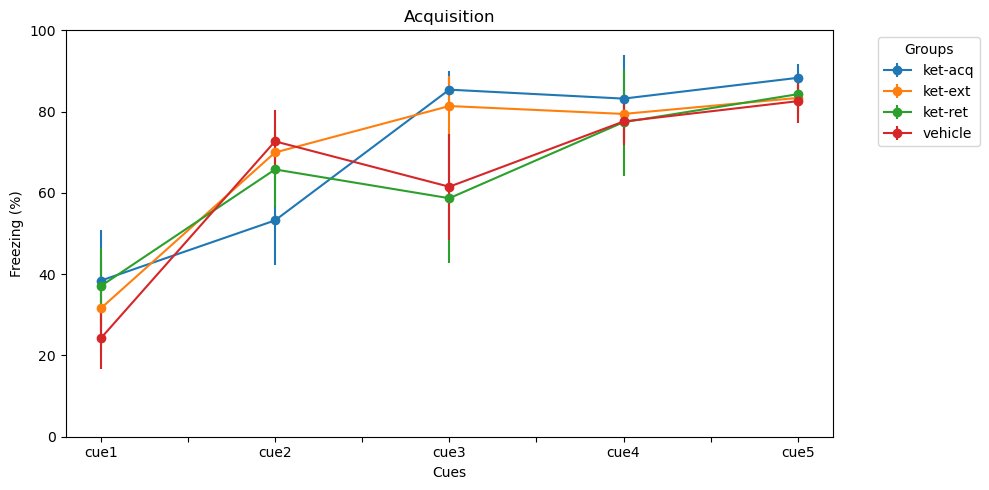


=== LINEAR MODEL ===
                            OLS Regression Results                            
Dep. Variable:               Freezing   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     8.949
Date:                Wed, 14 May 2025   Prob (F-statistic):           5.33e-09
Time:                        23:19:02   Log-Likelihood:                -646.61
No. Observations:                 140   AIC:                             1309.
Df Residuals:                     132   BIC:                             1333.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [74]:
#apply the plotting  and comparison functions to acquisition data
plotting(acq_data, title ="Acquisition", rename_group = {"avehicle" : "vehicle"}) #Correcting vehicle group name
comparingmodels(acq_tall)

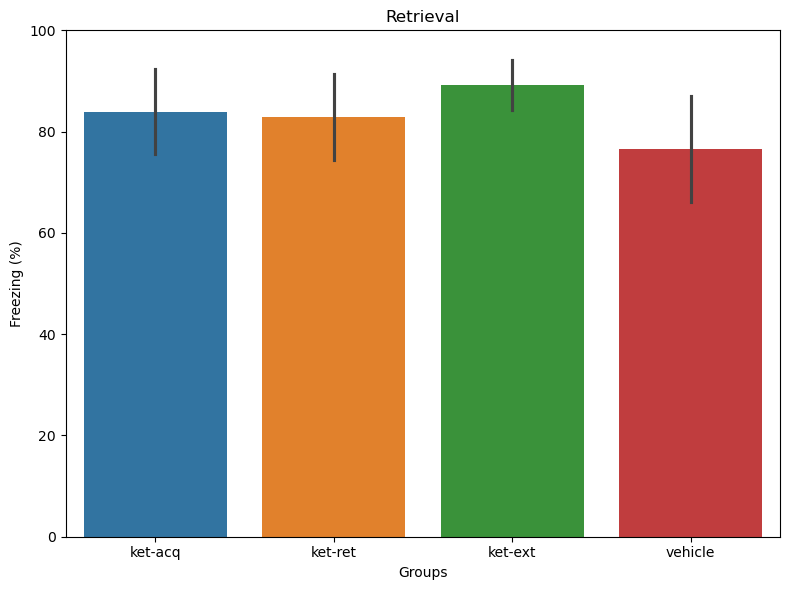

                 sum_sq    df         F    PR(>F)
C(groups)    561.634286   3.0  0.387809  0.762786
Residual   11585.782857  24.0       NaN       NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
ket-acq ket-ext   5.2286 0.9699 -27.1691 37.6262  False
ket-acq ket-ret  -1.0571 0.9997 -33.4548 31.3405  False
ket-acq vehicle  -7.3714 0.9221 -39.7691 25.0262  False
ket-ext ket-ret  -6.2857 0.9496 -38.6833 26.1119  False
ket-ext vehicle    -12.6 0.7089 -44.9976 19.7976  False
ket-ret vehicle  -6.3143 0.9489 -38.7119 26.0833  False
-------------------------------------------------------


In [76]:
#since retrieval has only one cue, run an ANOVA and plot as barplots
#Barplot


plt.figure(figsize=(8, 6))
ret_data['groups'] = ret_data['groups'].replace({'avehicle': 'vehicle'})
color_list = {"ket-acq" :"tab:blue", "ket-ret" :"tab:orange", "ket-ext" :"tab:green", "vehicle":"tab:red"}
order_list = ["ket-acq", "ket-ret", "ket-ext", "vehicle"]
sns.barplot(data=ret_data, x="groups", y="cue", errorbar="se", hue = "groups", order = order_list, palette = color_list)
plt.title("Retrieval")
plt.xlabel("Groups")
plt.ylabel("Freezing (%)")
plt.ylim(0,100)
plt.tight_layout()
plt.show()

# ANOVA model and post hocs
retrieval_anova = smf.ols("cue ~ C(groups)", data=ret_data).fit()
retrieval_anova_table = sm.stats.anova_lm(retrieval_anova, typ=2)
print(retrieval_anova_table)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

retrieval_tukey = pairwise_tukeyhsd(endog=ret_data["cue"], groups=ret_data["groups"], alpha=0.05)
print(retrieval_tukey)

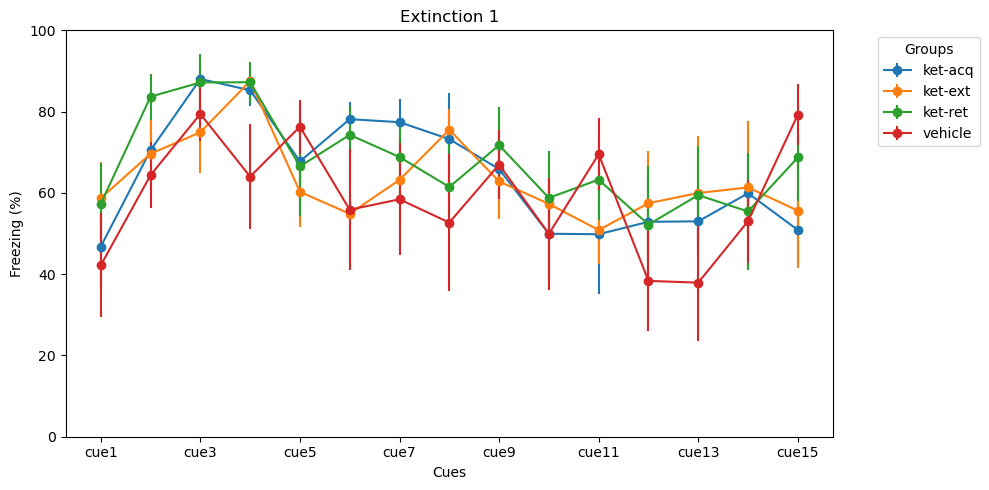


=== LINEAR MODEL ===
                            OLS Regression Results                            
Dep. Variable:               Freezing   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.907
Date:                Wed, 14 May 2025   Prob (F-statistic):             0.0733
Time:                        23:19:15   Log-Likelihood:                -645.07
No. Observations:                 140   AIC:                             1306.
Df Residuals:                     132   BIC:                             1330.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [78]:
#apply functions to extinction 1 data
plotting(ext1_data, title= "Extinction 1", rename_group = {"avehicle" : "vehicle"})
comparingmodels(ext1_tall)

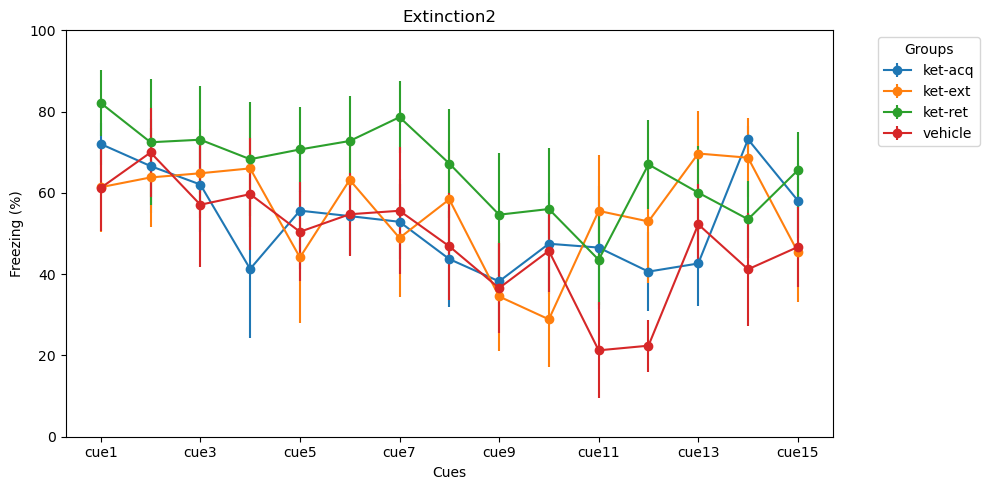


=== LINEAR MODEL ===
                            OLS Regression Results                            
Dep. Variable:               Freezing   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.235
Date:                Wed, 14 May 2025   Prob (F-statistic):              0.288
Time:                        23:19:17   Log-Likelihood:                -682.19
No. Observations:                 140   AIC:                             1380.
Df Residuals:                     132   BIC:                             1404.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [80]:
#apply functions to extinction 2 data
plotting(ext2_data, title = "Extinction2", rename_group = {"avehicle" : "vehicle"})
comparingmodels(ext2_tall)

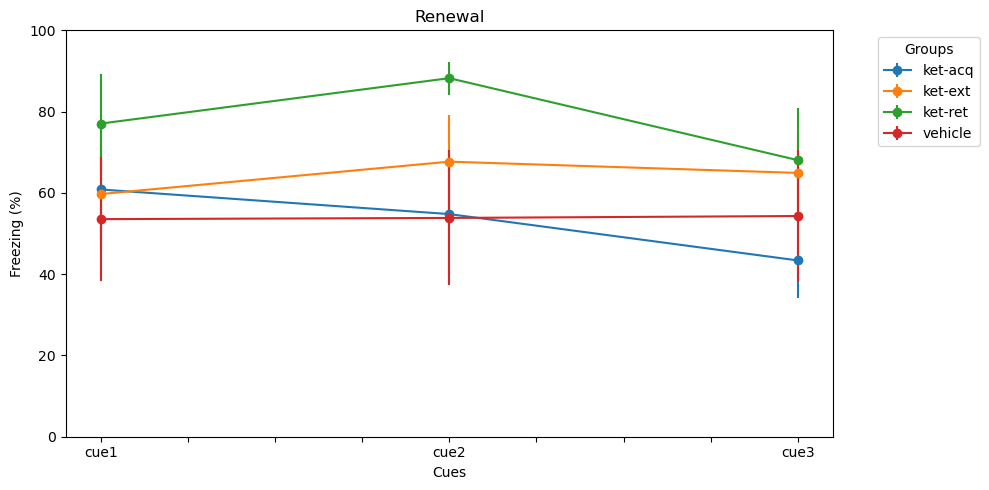


=== LINEAR MODEL ===
                            OLS Regression Results                            
Dep. Variable:               Freezing   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.206
Date:                Wed, 14 May 2025   Prob (F-statistic):              0.310
Time:                        23:19:24   Log-Likelihood:                -411.59
No. Observations:                  84   AIC:                             839.2
Df Residuals:                      76   BIC:                             858.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [82]:
#applying functions to renewal data
plotting(renewal_data, title = "Renewal", rename_group = {"avehicle" : "vehicle"})
comparingmodels(renewal_tall)

### WHY ANIMALS ARE NOT EXTINGUISHING?

In here I have also plotted the extinction phases with the time between cues.

    One when we look at the time between cues (which are ITI's in here), we also do not see a decrease in freezing.

    This means they are not only freezing the cues. The context in extinction is different than the other phases.

    One explanation might be they are also freezing the context. They might have been associating the cue with the new context as well, and freezing the new context with the cues. 

    Another possibility is that they are simply not moving at all, bored or sleepy (especially at the end). Since freezing in this experiment and also in the literature is defined as the absence of movement other than for breathing, sleeping for example might have been taken as freezing mistakenly.

    PS: Please acknowledge that in here the ITI is used wrong. In the literature the ITI (Inter-Trial Interval) is defined as the time between from ONSET of one cue to ONSET of the next cue. While in here it is used as from OFFSET of one cue to ONSET of the next one.

In [84]:
ext1_ITI_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'ext1_ITI')

print(ext1_ITI_data)

     groups  cue 1       ITI 1   cue 2       ITI 2  cue 3       ITI 3   cue 4  \
0   vehicle   61.8   84.512738   84.20   86.936937   56.2   77.908620   88.00   
1   vehicle   58.0         NaN   33.35         NaN   55.8         NaN   71.05   
2   vehicle   11.0   30.031612   57.80   87.602852   96.4   99.528968   96.80   
3   vehicle    0.0   21.952317   65.20   76.266340   87.8   98.735777   30.60   
4   vehicle   96.2   99.443826   98.60   99.311235  100.0  100.000000   99.40   
5   vehicle   18.6   52.482648   60.00   86.685289   77.6   79.421580   51.60   
6   vehicle   49.6   60.306476   51.40   52.171461   82.2   65.655289   10.60   
7   ket-acq   46.2   49.036085   67.00   77.356866   84.8   83.463882   68.80   
8   ket-acq   17.6   92.699011   87.20   90.729567   92.2   84.634635   82.40   
9   ket-acq   75.2   93.931732   87.20   96.575342   90.2   96.237337   97.60   
10  ket-acq   75.2   91.819222   85.40   91.624482   99.4   90.584416   86.00   
11  ket-acq   34.2   92.6675

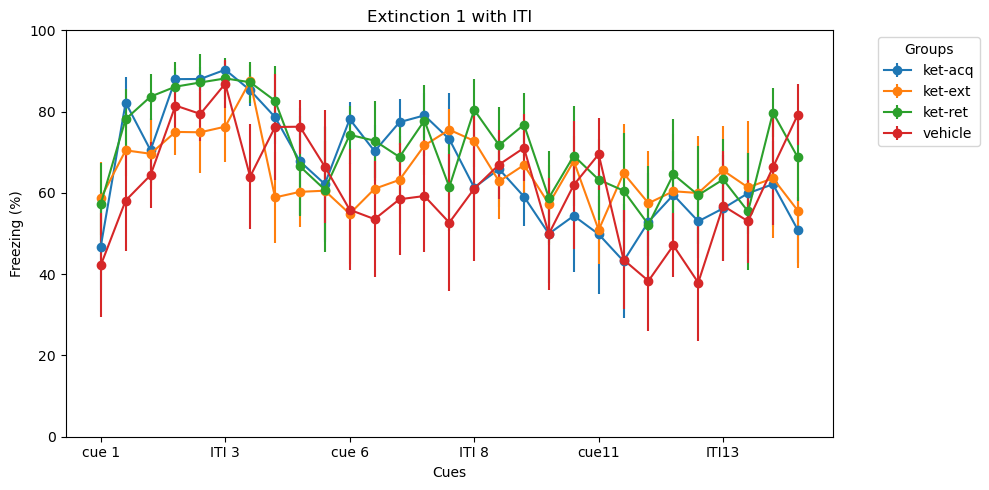

In [86]:
plotting(ext1_ITI_data, title ="Extinction 1 with ITI", rename_group = {"avehicle" : "vehicle"})

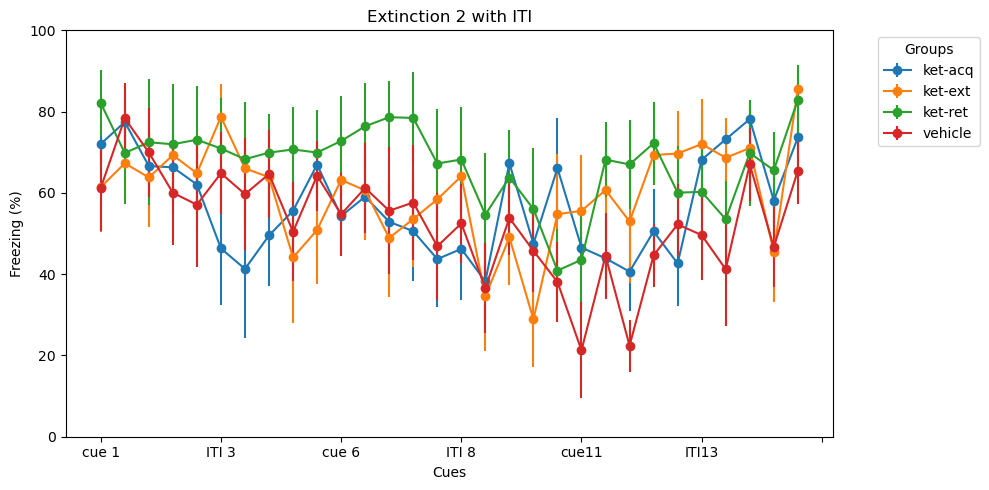

In [88]:
ext2_ITI_data = pd.read_excel(r"C:\Users\asyar\OneDrive\Desktop\Foundations4 Final Project\FC_data.xlsx", sheet_name = 'ext2_ITI')

#print(ext2_ITI_data)

plotting(ext2_ITI_data, title ="Extinction 2 with ITI", rename_group = {"avehicle" : "vehicle"})

## Lastly I have not made any power analysis

Since none of my result was close to be significant and in animal studies 7 is a normal sample size. 